In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, accuracy_score,
                            precision_score, recall_score, f1_score)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')
import joblib

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn Info:")
print(df.info())
df.head()

Dataset Shape: (7043, 21)

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Strea

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data = df.copy()

# Drop customerID (not useful for modeling)
data = data.drop('customerID', axis=1)

# Handle TotalCharges - it's an object type but should be numeric
print("\nUnique values in TotalCharges (first 10):", data['TotalCharges'].unique()[:10])

# Convert TotalCharges to numeric (some are empty strings)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Fill missing TotalCharges with 0 (these are new customers with 0 tenure)
data['TotalCharges'].fillna(0, inplace=True)

# Convert Churn to binary
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

print("\nMissing values after cleaning:")
print(data.isnull().sum())

print("\nChurn Distribution:")
print(data['Churn'].value_counts())
print(f"\nChurn Rate: {data['Churn'].mean():.2%}")



Unique values in TotalCharges (first 10): ['29.85' '1889.5' '108.15' '1840.75' '151.65' '820.5' '1949.4' '301.9'
 '3046.05' '3487.95']

Missing values after cleaning:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Churn Distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn Rate: 26.54%


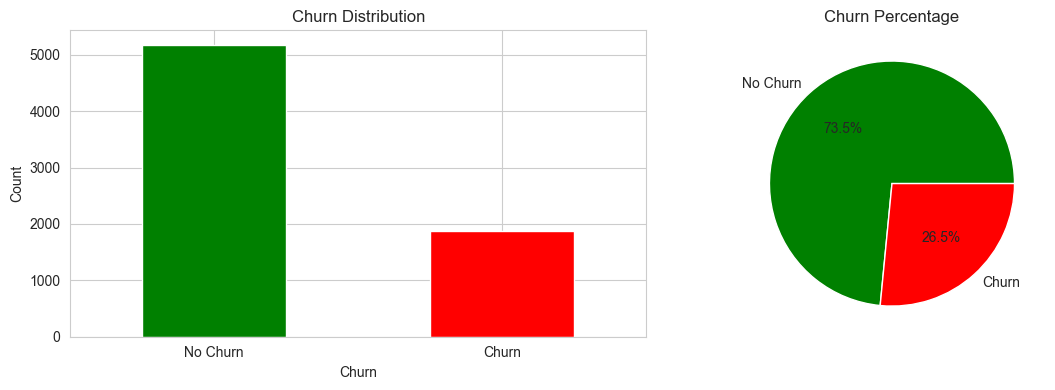

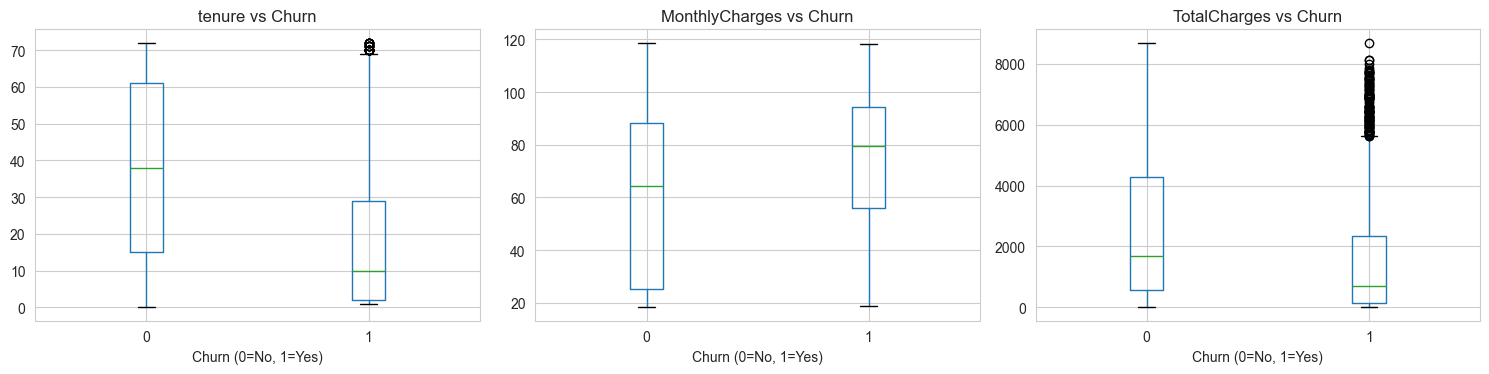

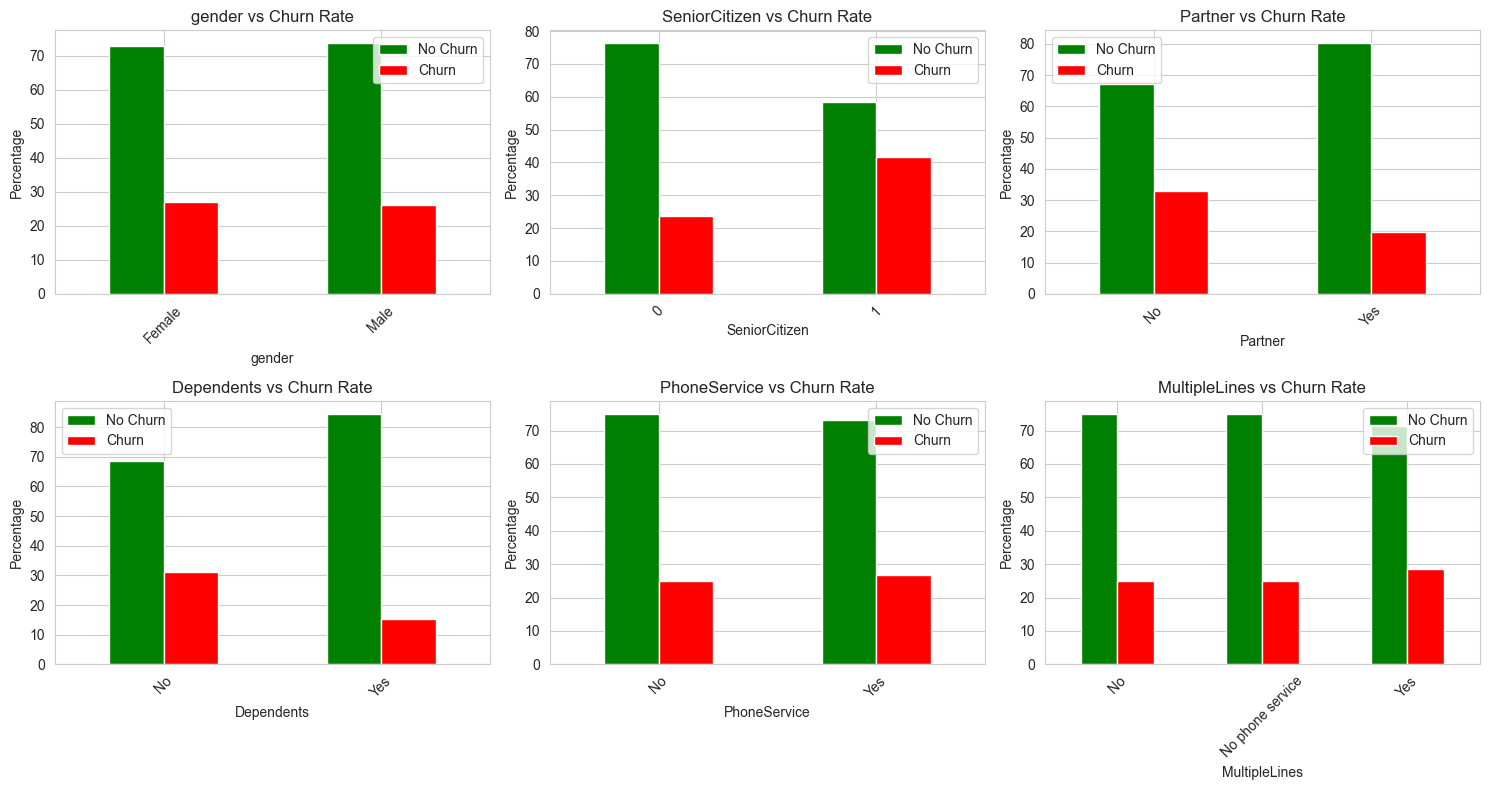


KEY INSIGHTS

Churn rate by Contract Type:
Contract
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Churn, dtype: float64

Churn rate by Tenure Groups:
tenure_group
0-1 year     0.476782
1-2 years    0.287109
2-4 years    0.203890
4+ years     0.095132
Name: Churn, dtype: float64


In [4]:

# STEP 3: EXPLORATORY DATA ANALYSIS
# ============================================================================

# Churn distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
data['Churn'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Churn Distribution')
axes[0].set_xticklabels(['No Churn', 'Churn'], rotation=0)
axes[0].set_ylabel('Count')

data['Churn'].value_counts(normalize=True).plot(kind='pie', ax=axes[1], 
                                                  autopct='%1.1f%%',
                                                  colors=['green', 'red'],
                                                  labels=['No Churn', 'Churn'])
axes[1].set_title('Churn Percentage')
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()

# Numerical features vs Churn
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(numerical_cols):
    data.boxplot(column=col, by='Churn', ax=axes[i])
    axes[i].set_title(f'{col} vs Churn')
    axes[i].set_xlabel('Churn (0=No, 1=Yes)')
plt.suptitle('')
plt.tight_layout()
plt.show()

# Categorical features vs Churn
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                    'PhoneService', 'MultipleLines', 'InternetService',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

# Plot first 6 categorical features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(categorical_cols[:6]):
    ct = pd.crosstab(data[col], data['Churn'], normalize='index') * 100
    ct.plot(kind='bar', ax=axes[i], color=['green', 'red'])
    axes[i].set_title(f'{col} vs Churn Rate')
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel(col)
    axes[i].legend(['No Churn', 'Churn'])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Key insights visualization
print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

# Contract type impact
print("\nChurn rate by Contract Type:")
print(data.groupby('Contract')['Churn'].mean().sort_values(ascending=False))

# Tenure analysis
print("\nChurn rate by Tenure Groups:")
data['tenure_group'] = pd.cut(data['tenure'], bins=[0, 12, 24, 48, 73], 
                               labels=['0-1 year', '1-2 years', '2-4 years', '4+ years'])
print(data.groupby('tenure_group')['Churn'].mean())



In [5]:
model_data = data.copy()
if model_data["Churn"].dtype == "object":
    model_data["Churn"] = model_data["Churn"].map({"Yes": 1, "No": 0})
if "customerID" in model_data.columns:
    model_data = model_data.drop(columns=["customerID"])

X = model_data.drop('Churn', axis=1)
y = model_data['Churn']

# Ensure all columns are numeric types (convert any remaining categorical)
if "TotalCharges" in X.columns:
    X["TotalCharges"] = pd.to_numeric(X["TotalCharges"], errors="coerce")

X = pd.get_dummies(X, drop_first=True)

# 7) Replace inf values with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# 8) Fill NaN values using median (numeric only)
X = X.fillna(X.median(numeric_only=True))



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Churn rate in train: {y_train.mean():.2%}")
print(f"Churn rate in test: {y_test.mean():.2%}")



Training set: (5634, 33)
Test set: (1409, 33)
Churn rate in train: 26.54%
Churn rate in test: 26.54%


In [6]:
print("\n" + "="*60)
print("CLASS IMBALANCE ANALYSIS")
print("="*60)

churn_counts = y_train.value_counts()
print(f"No Churn (0): {churn_counts[0]} ({churn_counts[0]/len(y_train):.1%})")
print(f"Churn (1): {churn_counts[1]} ({churn_counts[1]/len(y_train):.1%})")
print(f"Imbalance Ratio: {churn_counts[0]/churn_counts[1]:.2f}:1")

# Calculate class weights for handling imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Computed Class Weights: {class_weight_dict}")

# Scale pos weight for XGBoost
scale_pos_weight = churn_counts[0] / churn_counts[1]
print(f"Scale Pos Weight (for XGBoost): {scale_pos_weight:.2f}")


CLASS IMBALANCE ANALYSIS
No Churn (0): 4139 (73.5%)
Churn (1): 1495 (26.5%)
Imbalance Ratio: 2.77:1
Computed Class Weights: {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}
Scale Pos Weight (for XGBoost): 2.77


In [7]:
print("\n" + "="*60)
print("TRAINING MODELS")
print("="*60)

# Dictionary to store models and results
models = {}
results = {}

# 1. LOGISTIC REGRESSION
print("\n1. Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model
print("✓ Logistic Regression trained")

# 2. RANDOM FOREST
print("\n2. Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_model
print("✓ Random Forest trained")

# 3. XGBOOST
print("\n3. Training XGBoost...")
# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_model
print("✓ XGBoost trained")



TRAINING MODELS

1. Training Logistic Regression...
✓ Logistic Regression trained

2. Training Random Forest...
✓ Random Forest trained

3. Training XGBoost...
✓ XGBoost trained


In [8]:
# STEP 6: HYPERPARAMETER TUNING
# ============================================================================

print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

from sklearn.model_selection import GridSearchCV

# Dictionary to store models and results
models = {}
results = {}

# 1. LOGISTIC REGRESSION with GridSearch
print("\n1. Tuning Logistic Regression...")
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    lr_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
lr_grid.fit(X_train_scaled, y_train)
lr_model = lr_grid.best_estimator_
models['Logistic Regression'] = lr_model

print(f"✓ Best params: {lr_grid.best_params_}")
print(f"✓ Best CV ROC-AUC: {lr_grid.best_score_:.4f}")

# 2. RANDOM FOREST with GridSearch
print("\n2. Tuning Random Forest...")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    rf_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train_scaled, y_train)
rf_model = rf_grid.best_estimator_
models['Random Forest'] = rf_model

print(f"✓ Best params: {rf_grid.best_params_}")
print(f"✓ Best CV ROC-AUC: {rf_grid.best_score_:.4f}")

# 3. XGBOOST with GridSearch
print("\n3. Tuning XGBoost...")
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss'
    ),
    xgb_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train_scaled, y_train)
xgb_model = xgb_grid.best_estimator_
models['XGBoost'] = xgb_model

print(f"✓ Best params: {xgb_grid.best_params_}")
print(f"✓ Best CV ROC-AUC: {xgb_grid.best_score_:.4f}")

print("\n✓ All models tuned!")


HYPERPARAMETER TUNING

1. Tuning Logistic Regression...
✓ Best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
✓ Best CV ROC-AUC: 0.8467

2. Tuning Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✓ Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 200}
✓ Best CV ROC-AUC: 0.8450

3. Tuning XGBoost...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
✓ Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
✓ Best CV ROC-AUC: 0.8466

✓ All models tuned!


In [9]:
# STEP 7: EVALUATE ALL MODELS
# ============================================================================

print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Print metrics
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))



MODEL EVALUATION

Logistic Regression
Accuracy:  0.7339
Precision: 0.4992
Recall:    0.7888
F1 Score:  0.6114
ROC-AUC:   0.8409

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.71      0.80      1035
       Churn       0.50      0.79      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.75      1409


Random Forest
Accuracy:  0.7672
Precision: 0.5432
Recall:    0.7727
F1 Score:  0.6380
ROC-AUC:   0.8450

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.77      0.83      1035
       Churn       0.54      0.77      0.64       374

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409


XGBoost
Accuracy:  0.7402
Precision: 0.5068
Recall:    0.7941
F


MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
Logistic Regression  0.733854   0.499154 0.788770  0.611399 0.840851
      Random Forest  0.767211   0.543233 0.772727  0.637969 0.845036
            XGBoost  0.740241   0.506826 0.794118  0.618750 0.844027

BEST PERFORMANCE BY METRIC
Accuracy    : Random Forest        (0.7672)
Precision   : Random Forest        (0.5432)
Recall      : XGBoost              (0.7941)
F1 Score    : Random Forest        (0.6380)
ROC-AUC     : Random Forest        (0.8450)

CLASS IMBALANCE HANDLING CHECK
Note: High Recall means we're catching churners (minority class)
      Balanced Precision/Recall means good handling of imbalance

Logistic Regression:
  Precision (Churn): 0.499
  Recall (Churn):    0.789
  Balance Score:     0.611

Random Forest:
  Precision (Churn): 0.543
  Recall (Churn):    0.773
  Balance Score:     0.638

XGBoost:
  Precision (Churn): 0.507
  Recall (Churn):    0.794
  Balance Score:     0.619


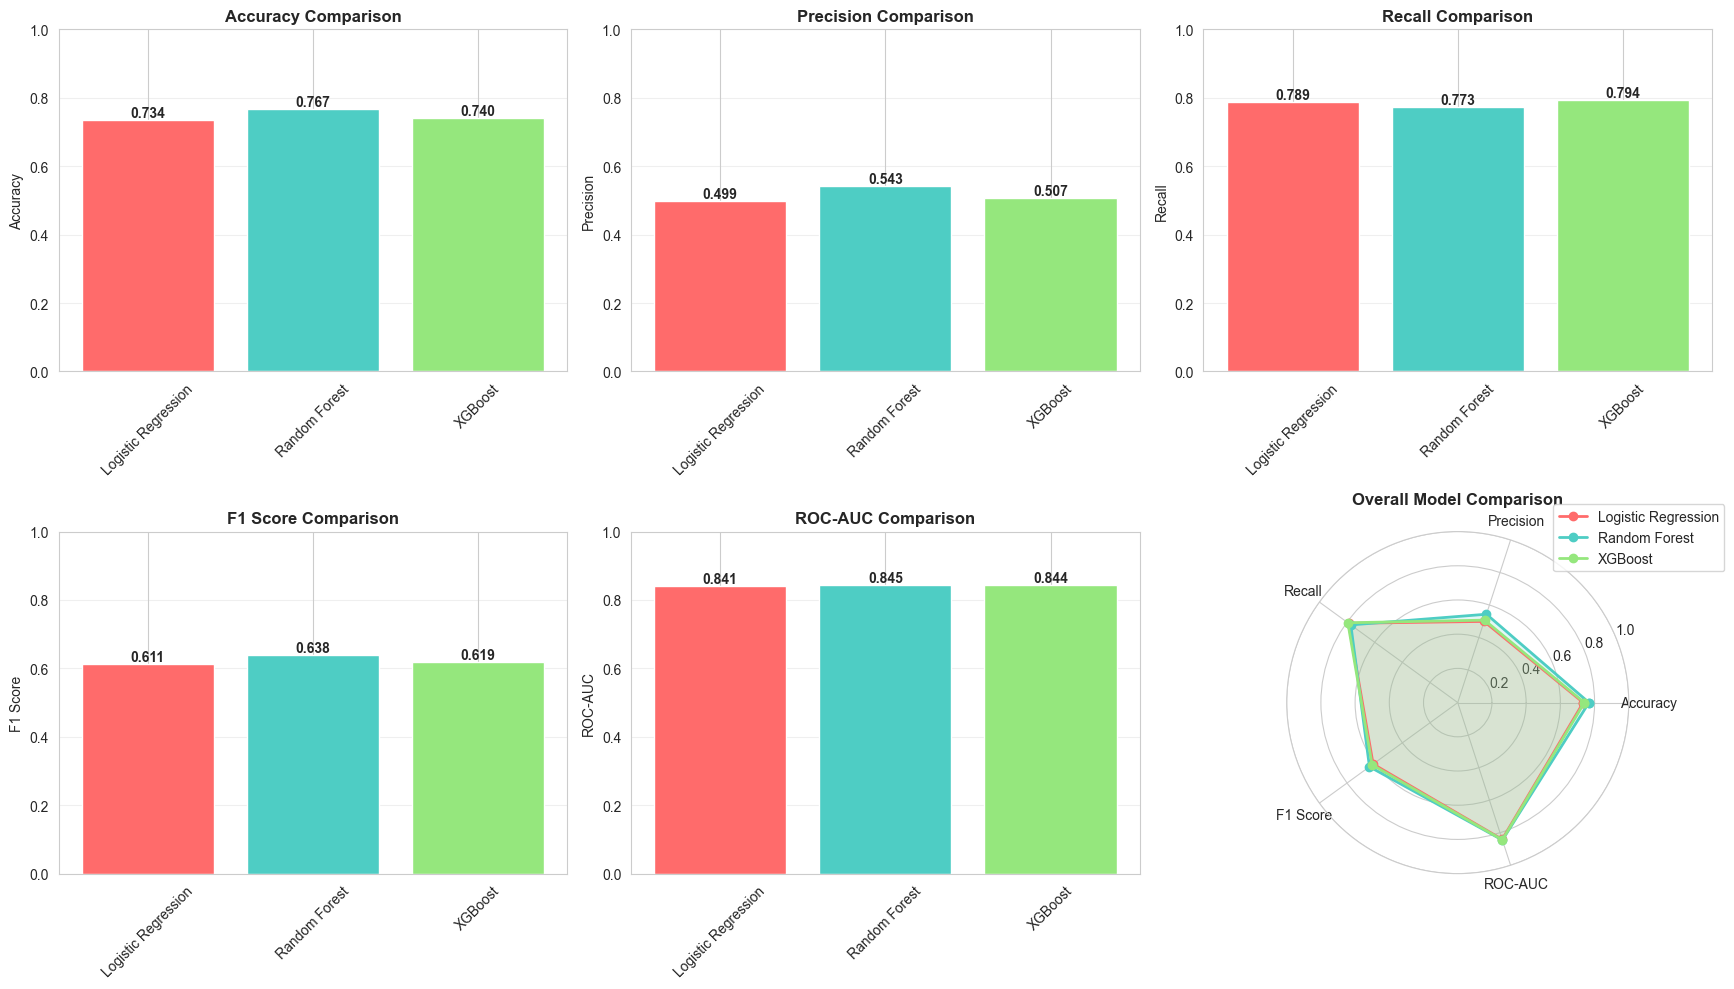

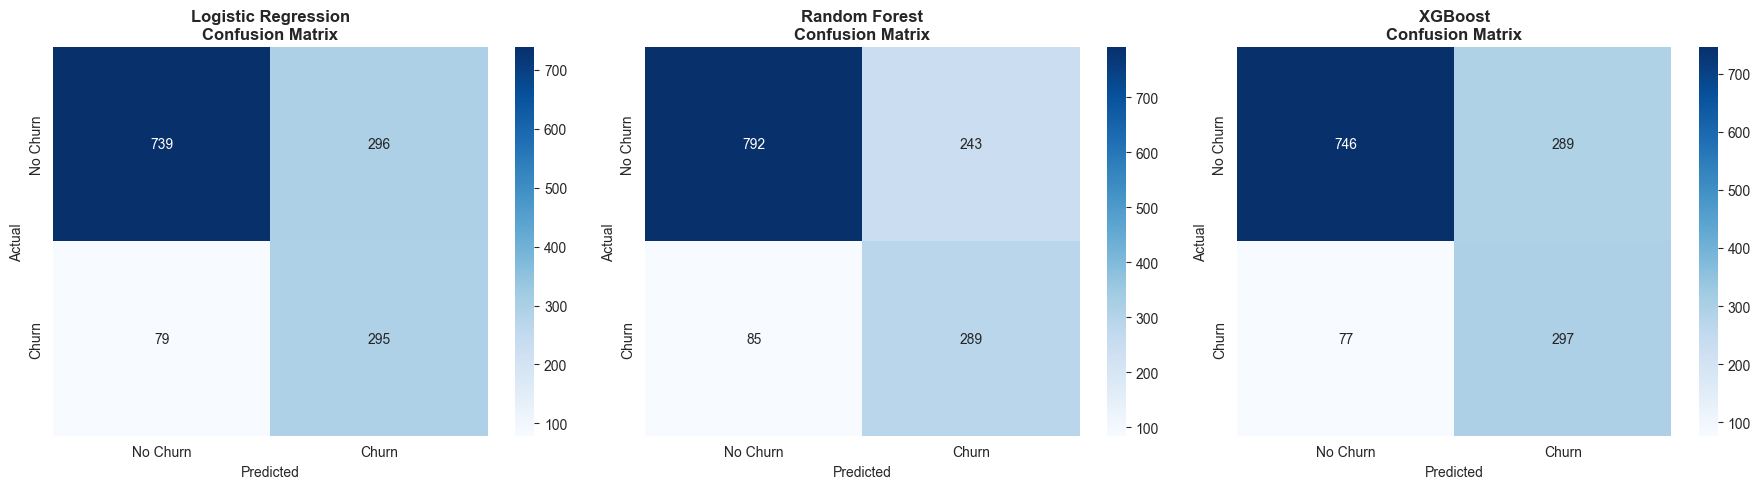

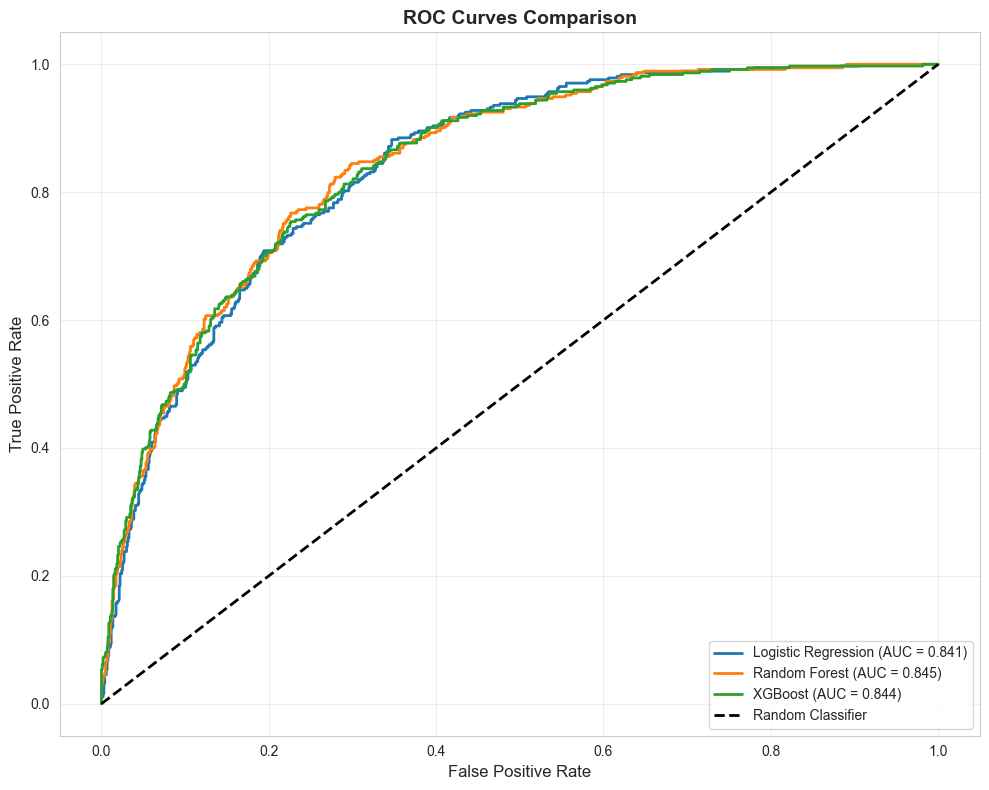

In [10]:
# STEP 8: MODEL COMPARISON VISUALIZATIONS
# ============================================================================

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1 Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Highlight best model for each metric
print("\n" + "="*60)
print("BEST PERFORMANCE BY METRIC")
print("="*60)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"{metric:12s}: {best_model:20s} ({best_value:.4f})")

# Check class imbalance handling effectiveness
print("\n" + "="*60)
print("CLASS IMBALANCE HANDLING CHECK")
print("="*60)
print("Note: High Recall means we're catching churners (minority class)")
print("      Balanced Precision/Recall means good handling of imbalance")
for name in results.keys():
    precision = results[name]['precision']
    recall = results[name]['recall']
    balance_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"\n{name}:")
    print(f"  Precision (Churn): {precision:.3f}")
    print(f"  Recall (Churn):    {recall:.3f}")
    print(f"  Balance Score:     {balance_score:.3f}")
    if recall < 0.5:
        print(f"  ⚠️  Warning: Low recall - missing many churners!")

# Bar chart comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
colors = ['#FF6B6B', '#4ECDC4', '#95E77D']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Model'], values, color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}',
                ha='center', va='bottom', fontweight='bold')

# Overall comparison radar chart
axes[5].remove()
ax = plt.subplot(2, 3, 6, projection='polar')

categories = metrics
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

for i, model_name in enumerate(comparison_df['Model']):
    values = comparison_df.iloc[i, 1:].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
    ax.fill(angles, values, alpha=0.15, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Overall Model Comparison', fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model) in enumerate(models.items()):
    cm = confusion_matrix(y_test, results[name]['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# ROC Curves Comparison
plt.figure(figsize=(10, 8))

for name in models.keys():
    y_pred_proba = results[name]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = results[name]['roc_auc']
    
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


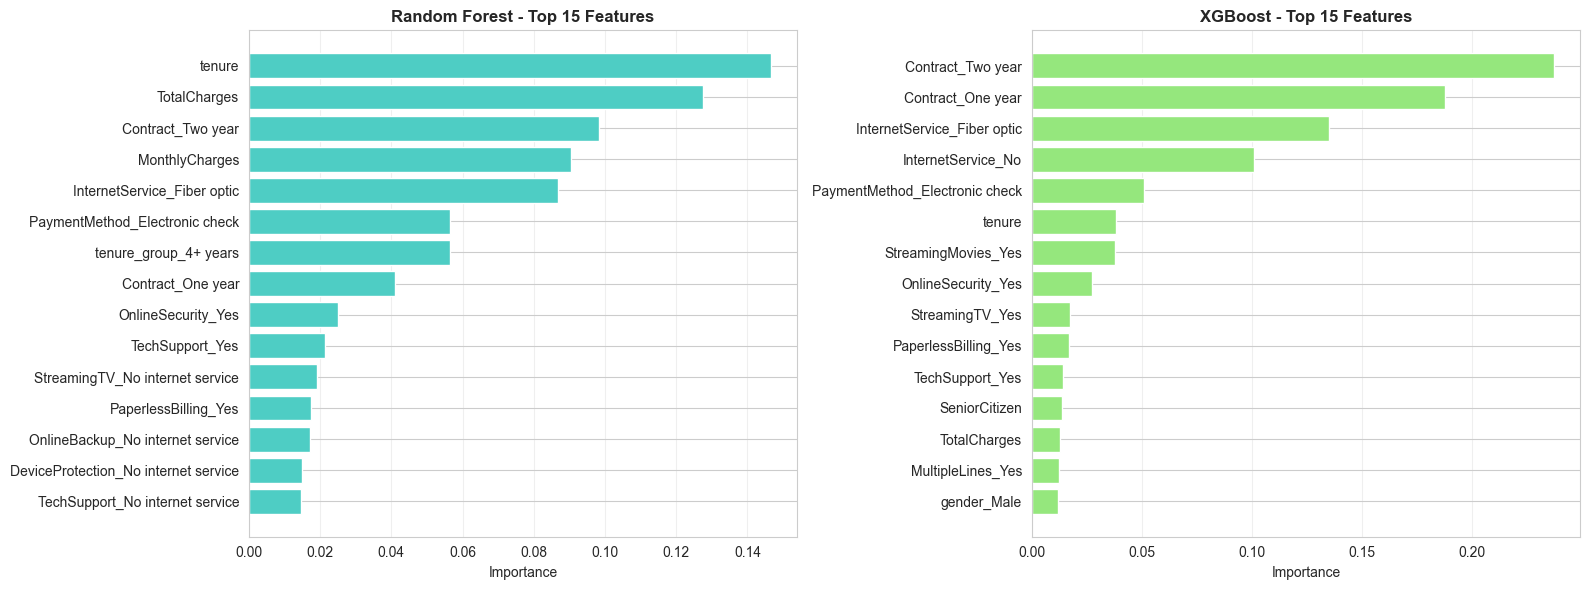


LOGISTIC REGRESSION - TOP 10 COEFFICIENTS
                           feature  coefficient
2                   MonthlyCharges    -2.046182
10     InternetService_Fiber optic     1.260918
1                           tenure    -1.081932
25               Contract_Two year    -0.667903
23             StreamingMovies_Yes     0.467402
21                 StreamingTV_Yes     0.455877
9                MultipleLines_Yes     0.308942
24               Contract_One year    -0.302814
3                     TotalCharges     0.219676
28  PaymentMethod_Electronic check     0.188047


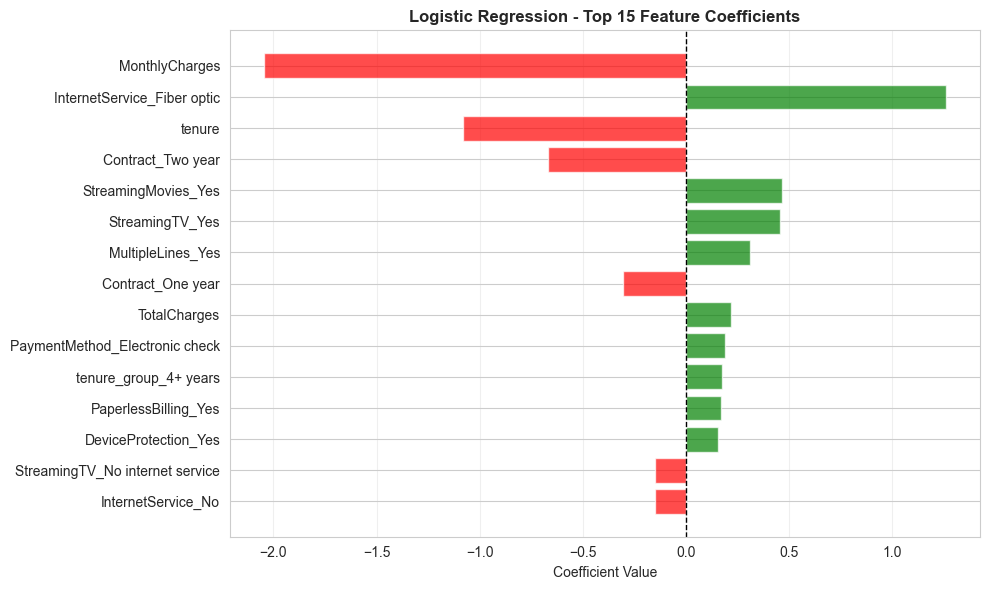

In [11]:
# STEP 9: FEATURE IMPORTANCE (for tree-based models)
# ============================================================================

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
top_rf = rf_importance.head(15)
axes[0].barh(range(len(top_rf)), top_rf['importance'], color='#4ECDC4')
axes[0].set_yticks(range(len(top_rf)))
axes[0].set_yticklabels(top_rf['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 15 Features', fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# XGBoost
top_xgb = xgb_importance.head(15)
axes[1].barh(range(len(top_xgb)), top_xgb['importance'], color='#95E77D')
axes[1].set_yticks(range(len(top_xgb)))
axes[1].set_yticklabels(top_xgb['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost - Top 15 Features', fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Logistic Regression Coefficients
lr_coef = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\n" + "="*60)
print("LOGISTIC REGRESSION - TOP 10 COEFFICIENTS")
print("="*60)
print(lr_coef.head(10))

plt.figure(figsize=(10, 6))
top_coef = lr_coef.head(15)
colors_coef = ['red' if x < 0 else 'green' for x in top_coef['coefficient']]
plt.barh(range(len(top_coef)), top_coef['coefficient'], color=colors_coef, alpha=0.7)
plt.yticks(range(len(top_coef)), top_coef['feature'])
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression - Top 15 Feature Coefficients', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
# STEP 10: SELECT BEST MODEL AND SAVE
# ============================================================================

# Select best model based on ROC-AUC
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = models[best_model_name]
best_roc_auc = results[best_model_name]['roc_auc']

print("\n" + "="*60)
print("BEST MODEL SELECTION")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"ROC-AUC Score: {best_roc_auc:.4f}")

# Save all models
import joblib

for name, model in models.items():
    model_filename = name.lower().replace(' ', '_') + '_model.pkl'
    joblib.dump(model, model_filename)
    print(f"✓ Saved: {model_filename}")

# Save the best model separately for easy access
joblib.dump(best_model, 'churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'feature_names.pkl')

# Save model comparison
comparison_df.to_csv('model_comparison.csv', index=False)

# Save cleaned data for segmentation
model_data.to_csv('cleaned_telco_data.csv', index=False)

print("\n✓ Best model saved as 'churn_model.pkl'")
print("✓ All models saved!")
print("✓ Cleaned data saved!")
print("✓ Week 1 Complete!")
print("\n📊 Summary:")
print(f"   - Best Model: {best_model_name}")
print(f"   - Best ROC-AUC: {best_roc_auc:.3f}")
print(f"   - Features: {len(X.columns)}")



BEST MODEL SELECTION
Best Model: Random Forest
ROC-AUC Score: 0.8450
✓ Saved: logistic_regression_model.pkl
✓ Saved: random_forest_model.pkl
✓ Saved: xgboost_model.pkl

✓ Best model saved as 'churn_model.pkl'
✓ All models saved!
✓ Cleaned data saved!
✓ Week 1 Complete!

📊 Summary:
   - Best Model: Random Forest
   - Best ROC-AUC: 0.845
   - Features: 33


In [13]:
data = pd.read_csv('cleaned_telco_data.csv')
print("Data loaded:", data.shape)
print(f"Churn rate: {data['Churn'].mean():.2%}")

Data loaded: (7043, 21)
Churn rate: 26.54%


In [15]:
# STEP 2: SELECT FEATURES FOR CLUSTERING
# ============================================================================
print(data.columns.tolist())
# Create num_services feature from service columns
service_cols = [
    'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

data['num_services'] = (data[service_cols] == 'Yes').sum(axis=1)

# We'll use behavioral and value features for segmentation
clustering_features = [
    'tenure',                    # How long they've been customers
    'MonthlyCharges',           # Monthly spend
    'TotalCharges',             # Total lifetime value
    'num_services',             # Number of services used
    'Contract',                 # Contract type (encoded)
    'InternetService',          # Internet service type
    'PaymentMethod',            # Payment method
    'PaperlessBilling'          # Billing preference
]

# Create clustering dataset
cluster_data = data[clustering_features].copy()

print("\nFeatures for clustering:")
for feat in clustering_features:
    print(f"  - {feat}")


# STEP 3: SCALE FEATURES (FORCE 8 COLUMNS VERSION)

from sklearn.preprocessing import StandardScaler
import pandas as pd

cluster_data = cluster_data.copy()

# Ensure numeric columns are numeric
cluster_data["TotalCharges"] = pd.to_numeric(
    cluster_data["TotalCharges"], errors="coerce"
)

num_cols = ["tenure", "MonthlyCharges", "TotalCharges", "num_services"]
cat_cols = ["Contract", "InternetService", "PaymentMethod", "PaperlessBilling"]

# Fill numeric NaNs
cluster_data[num_cols] = cluster_data[num_cols].fillna(
    cluster_data[num_cols].median()
)

# 🔴 Encode categorical columns as integers (1 column each)
for col in cat_cols:
    cluster_data[col] = cluster_data[col].astype("category").cat.codes

# Scale everything
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data[num_cols + cat_cols])

print("Final scaled data shape:", cluster_scaled.shape)



['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'tenure_group', 'num_services']

Features for clustering:
  - tenure
  - MonthlyCharges
  - TotalCharges
  - num_services
  - Contract
  - InternetService
  - PaymentMethod
  - PaperlessBilling
Final scaled data shape: (7043, 8)


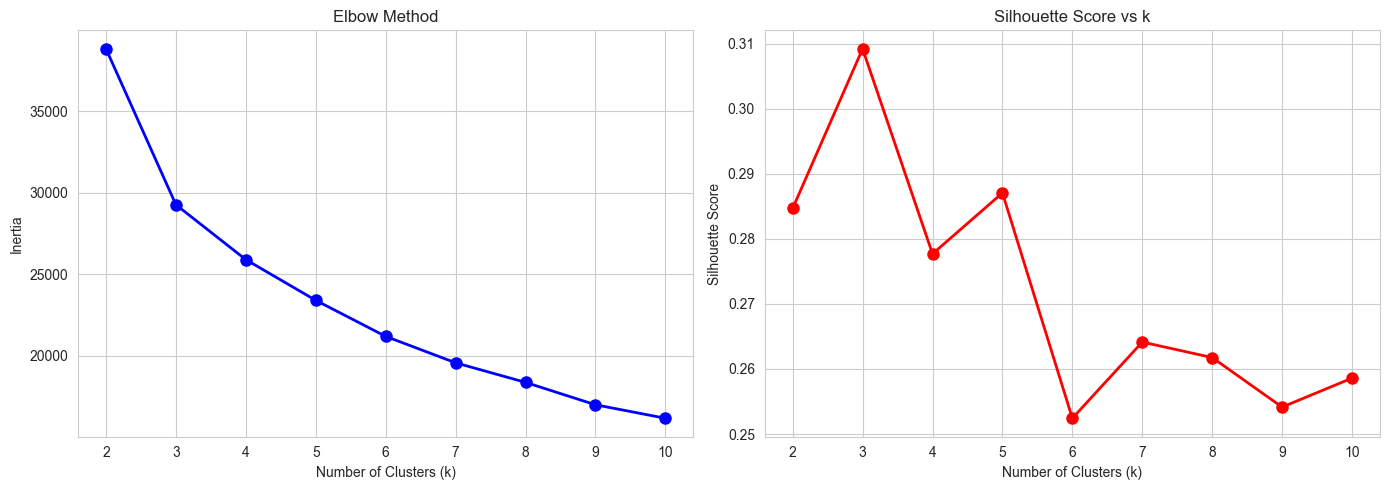


Silhouette Scores:
  k=2: 0.285
  k=3: 0.309
  k=4: 0.278
  k=5: 0.287
  k=6: 0.252
  k=7: 0.264
  k=8: 0.262
  k=9: 0.254
  k=10: 0.259


In [16]:
# STEP 4: FIND OPTIMAL NUMBER OF CLUSTERS
# ============================================================================

# Elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(cluster_scaled, kmeans.labels_))

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs k')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\nSilhouette Scores:")
for k, score in zip(K_range, silhouette_scores):
    print(f"  k={k}: {score:.3f}")


In [41]:
# STEP 5: CREATE SEGMENTS (k=4 or k=5)
# ============================================================================

# Choose optimal k (usually 4 or 5 works well)
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data['Segment'] = kmeans.fit_predict(cluster_scaled)

print(f"\n✓ Created {optimal_k} customer segments")
print("\nSegment Distribution:")
print(data['Segment'].value_counts().sort_index())



✓ Created 4 customer segments

Segment Distribution:
Segment
0    2347
1    1980
2    1526
3    1190
Name: count, dtype: int64


In [42]:
# STEP 6: ANALYZE SEGMENTS
# ============================================================================

print("\n" + "="*80)
print("SEGMENT PROFILES")
print("="*80)

# Analyze each segment
segment_summary = data.groupby('Segment').agg({
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'num_services': 'mean',
    'Churn': 'mean'
}).round(2)

segment_summary['Count'] = data.groupby('Segment').size()
segment_summary['Churn_Rate_%'] = (segment_summary['Churn'] * 100).round(1)

print("\nSegment Statistics:")
print(segment_summary)



SEGMENT PROFILES

Segment Statistics:
         tenure  MonthlyCharges  TotalCharges  num_services  Churn  Count  \
Segment                                                                     
0         17.02           72.43       1235.21          3.00   0.49   2347   
1         59.77           90.49       5400.93          5.73   0.13   1980   
2         30.55           21.08        662.60          1.22   0.07   1526   
3         19.39           62.85       1220.29          2.87   0.29   1190   

         Churn_Rate_%  
Segment                
0                49.0  
1                13.0  
2                 7.0  
3                29.0  


In [43]:
# STEP 7: NAME THE SEGMENTS
# ============================================================================

# Analyze characteristics to name segments
segment_names = {}

for seg in range(optimal_k):
    seg_data = data[data['Segment'] == seg]
    
    avg_tenure = seg_data['tenure'].mean()
    avg_charges = seg_data['MonthlyCharges'].mean()
    avg_services = seg_data['num_services'].mean()
    churn_rate = seg_data['Churn'].mean()
    
    # Name based on characteristics
    if avg_tenure < 20 and churn_rate > 0.4:
        name = "At-Risk Newcomers"
    elif avg_tenure > 50 and churn_rate < 0.15:
        name = "Loyal Champions"
    elif avg_charges > 70 and avg_services > 4:
        name = "High-Value Users"
    elif avg_charges < 40 and avg_services < 3:
        name = "Budget Conscious"
    else:
        name = f"Segment {seg}"
    
    segment_names[seg] = name
    
    print(f"\n{name} (Segment {seg}):")
    print(f"  - Avg Tenure: {avg_tenure:.1f} months")
    print(f"  - Avg Monthly Charges: ${avg_charges:.2f}")
    print(f"  - Avg Services: {avg_services:.1f}")
    print(f"  - Churn Rate: {churn_rate:.1%}")
    print(f"  - Size: {len(seg_data)} customers ({len(seg_data)/len(data):.1%})")

# Add segment names to data
data['Segment_Name'] = data['Segment'].map(segment_names)



At-Risk Newcomers (Segment 0):
  - Avg Tenure: 17.0 months
  - Avg Monthly Charges: $72.43
  - Avg Services: 3.0
  - Churn Rate: 48.9%
  - Size: 2347 customers (33.3%)

Loyal Champions (Segment 1):
  - Avg Tenure: 59.8 months
  - Avg Monthly Charges: $90.49
  - Avg Services: 5.7
  - Churn Rate: 13.3%
  - Size: 1980 customers (28.1%)

Budget Conscious (Segment 2):
  - Avg Tenure: 30.5 months
  - Avg Monthly Charges: $21.08
  - Avg Services: 1.2
  - Churn Rate: 7.4%
  - Size: 1526 customers (21.7%)

Segment 3 (Segment 3):
  - Avg Tenure: 19.4 months
  - Avg Monthly Charges: $62.85
  - Avg Services: 2.9
  - Churn Rate: 29.0%
  - Size: 1190 customers (16.9%)


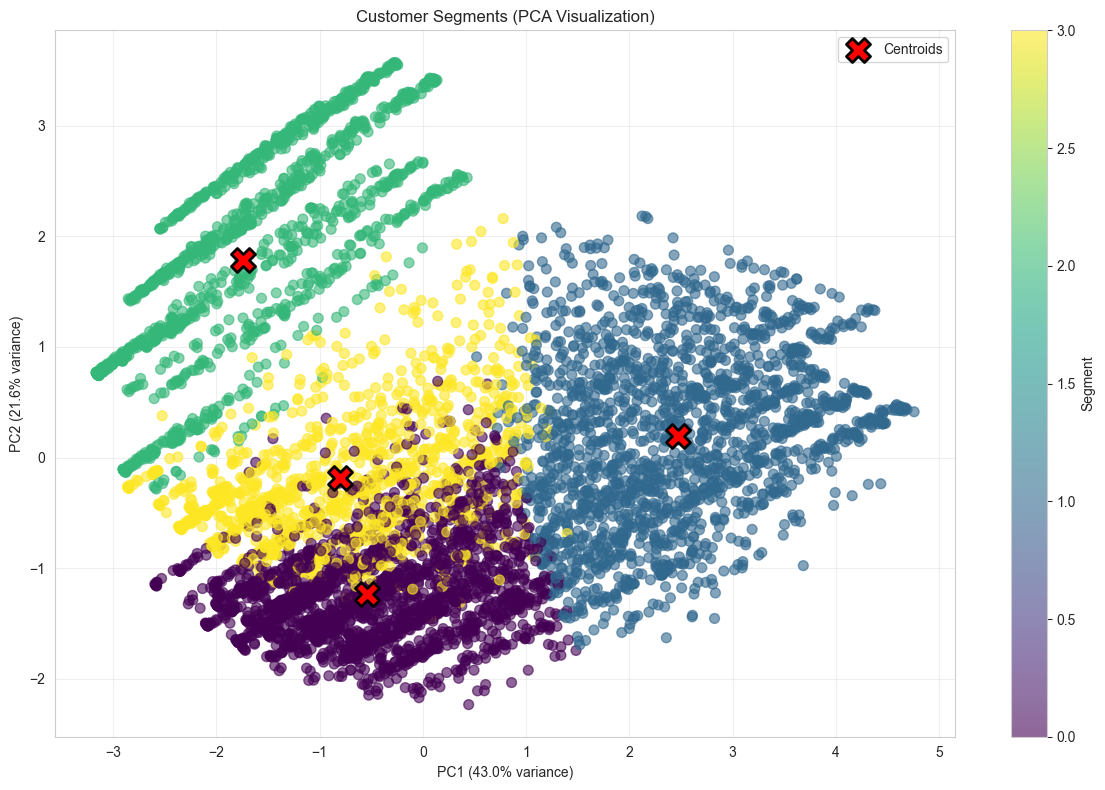

TypeError: agg function failed [how->mean,dtype->object]

In [44]:
# STEP 8: VISUALIZE SEGMENTS
# ============================================================================

# 2D visualization using PCA
pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(cluster_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(cluster_pca[:, 0], cluster_pca[:, 1], 
                     c=data['Segment'], cmap='viridis', 
                     alpha=0.6, s=50)

# Add centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
           c='red', marker='X', s=300, edgecolors='black', linewidths=2,
           label='Centroids')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Customer Segments (PCA Visualization)')
plt.colorbar(scatter, label='Segment')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Segment characteristics heatmap
segment_chars = data.groupby('Segment_Name')[clustering_features].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(segment_chars.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Average Value'})
plt.title('Segment Characteristics Heatmap')
plt.xlabel('Segment')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Churn rate by segment
plt.figure(figsize=(10, 6))
churn_by_segment = data.groupby('Segment_Name')['Churn'].mean().sort_values(ascending=False)
bars = plt.bar(range(len(churn_by_segment)), churn_by_segment.values * 100)

# Color bars by churn rate
colors = plt.cm.RdYlGn_r(churn_by_segment.values)
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xticks(range(len(churn_by_segment)), churn_by_segment.index, rotation=45, ha='right')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Customer Segment')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
# STEP 9: SEGMENT PROFILES FOR INTERVENTIONS
# ============================================================================

print("\n" + "="*80)
print("INTERVENTION RECOMMENDATIONS BY SEGMENT")
print("="*80)

for seg in range(optimal_k):
    seg_data = data[data['Segment'] == seg]
    name = segment_names[seg]
    
    print(f"\n{name}:")
    print(f"  Size: {len(seg_data)} ({len(seg_data)/len(data):.1%})")
    print(f"  Churn Risk: {seg_data['Churn'].mean():.1%}")
    print(f"  Avg Monthly Value: ${seg_data['MonthlyCharges'].mean():.2f}")
    print(f"  Avg Tenure: {seg_data['tenure'].mean():.1f} months")
    
    # Suggest intervention based on profile
    churn_rate = seg_data['Churn'].mean()
    avg_charges = seg_data['MonthlyCharges'].mean()
    avg_tenure = seg_data['tenure'].mean()
    
    if churn_rate > 0.4 and avg_tenure < 20:
        intervention = "🎯 Onboarding support + feature tutorials"
    elif churn_rate > 0.3 and avg_charges > 70:
        intervention = "💰 Loyalty rewards + premium support"
    elif churn_rate > 0.25 and avg_charges < 40:
        intervention = "💵 Targeted discounts (10-15%)"
    elif churn_rate < 0.15:
        intervention = "⭐ Minimal - focus on retention, upsell opportunities"
    else:
        intervention = "📞 Proactive customer success outreach"
    
    print(f"  Suggested Intervention: {intervention}")



INTERVENTION RECOMMENDATIONS BY SEGMENT

At-Risk Newcomers:
  Size: 2347 (33.3%)
  Churn Risk: 48.9%
  Avg Monthly Value: $72.43
  Avg Tenure: 17.0 months
  Suggested Intervention: 🎯 Onboarding support + feature tutorials

Loyal Champions:
  Size: 1980 (28.1%)
  Churn Risk: 13.3%
  Avg Monthly Value: $90.49
  Avg Tenure: 59.8 months
  Suggested Intervention: ⭐ Minimal - focus on retention, upsell opportunities

Budget Conscious:
  Size: 1526 (21.7%)
  Churn Risk: 7.4%
  Avg Monthly Value: $21.08
  Avg Tenure: 30.5 months
  Suggested Intervention: ⭐ Minimal - focus on retention, upsell opportunities

Segment 3:
  Size: 1190 (16.9%)
  Churn Risk: 29.0%
  Avg Monthly Value: $62.85
  Avg Tenure: 19.4 months
  Suggested Intervention: 📞 Proactive customer success outreach


In [46]:
# STEP 10: SAVE RESULTS
# ============================================================================

# Save segmented data
data.to_csv('segmented_telco_data.csv', index=False)

# Save segment profiles
segment_summary.to_csv('segment_profiles.csv')

# Save for Week 3
import joblib
joblib.dump(segment_names, 'segment_names.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'clustering_scaler.pkl')

print("\n✓ Segmented data saved!")
print("✓ Segment profiles saved!")


✓ Segmented data saved!
✓ Segment profiles saved!


In [47]:
data = pd.read_csv('segmented_telco_data.csv')
segment_names = joblib.load('segment_names.pkl')
churn_model = joblib.load('churn_model.pkl')
scaler = joblib.load('scaler.pkl')

print("Data loaded:", data.shape)
print(f"Total customers: {len(data)}")
print(f"Overall churn rate: {data['Churn'].mean():.2%}")


Data loaded: (7043, 33)
Total customers: 7043
Overall churn rate: 26.54%


In [48]:
# STEP 2: DEFINE INTERVENTIONS
# ============================================================================

interventions = {
    'no_action': {
        'name': 'No Action',
        'cost': 0,
        'effectiveness': 0,  # No change in churn
        'description': 'Do nothing - baseline'
    },
    'discount_10': {
        'name': '10% Discount',
        'cost_per_customer': lambda row: row['MonthlyCharges'] * 0.10 * 3,  # 3 months
        'effectiveness': 0.15,  # Reduces churn by 15%
        'description': '10% off for 3 months'
    },
    'discount_20': {
        'name': '20% Discount',
        'cost_per_customer': lambda row: row['MonthlyCharges'] * 0.20 * 3,
        'effectiveness': 0.30,  # Reduces churn by 30%
        'description': '20% off for 3 months'
    },
    'feature_tutorial': {
        'name': 'Feature Tutorial',
        'cost_per_customer': lambda row: 15,  # Fixed cost
        'effectiveness': 0.20,  # Reduces churn by 20%
        'description': 'Personalized onboarding session'
    },
    'premium_support': {
        'name': 'Premium Support',
        'cost_per_customer': lambda row: 50,  # Customer success call
        'effectiveness': 0.25,  # Reduces churn by 25%
        'description': 'Dedicated support agent'
    },
    'loyalty_reward': {
        'name': 'Loyalty Reward',
        'cost_per_customer': lambda row: 30,  # One-time reward
        'effectiveness': 0.18,  # Reduces churn by 18%
        'description': 'Gift card or service upgrade'
    }
}

print("\n" + "="*60)
print("AVAILABLE INTERVENTIONS")
print("="*60)
for key, inter in interventions.items():
    if key != 'no_action':
        print(f"\n{inter['name']}:")
        print(f"  Description: {inter['description']}")
        print(f"  Effectiveness: Reduces churn by {inter['effectiveness']*100:.0f}%")



AVAILABLE INTERVENTIONS

10% Discount:
  Description: 10% off for 3 months
  Effectiveness: Reduces churn by 15%

20% Discount:
  Description: 20% off for 3 months
  Effectiveness: Reduces churn by 30%

Feature Tutorial:
  Description: Personalized onboarding session
  Effectiveness: Reduces churn by 20%

Premium Support:
  Description: Dedicated support agent
  Effectiveness: Reduces churn by 25%

Loyalty Reward:
  Description: Gift card or service upgrade
  Effectiveness: Reduces churn by 18%


In [51]:
# STEP 3: ASSIGN INTERVENTIONS TO SEGMENTS
# ============================================================================

# Define intervention strategy for each segment
segment_interventions = {}

for seg_id, seg_name in segment_names.items():
    seg_data = data[data['Segment'] == seg_id]
    avg_churn = seg_data['Churn'].mean()
    avg_charges = seg_data['MonthlyCharges'].mean()
    avg_tenure = seg_data['tenure'].mean()
    
    # Decision logic for intervention assignment
    if 'Newcomer' in seg_name or (avg_tenure < 20 and avg_churn > 0.4):
        intervention = 'feature_tutorial'
    elif 'High-Value' in seg_name or avg_charges > 70:
        intervention = 'premium_support'
    elif 'Budget' in seg_name or avg_charges < 40:
        intervention = 'discount_10'
    elif 'Loyal' in seg_name and avg_churn < 0.15:
        intervention = 'no_action'  # Low risk, don't spend
    else:
        intervention = 'discount_20'
    
    segment_interventions[seg_name] = intervention
    
    print(f"\n{seg_name}:")
    print(f"  Churn Risk: {avg_churn:.1%}")
    print(f"  Assigned Intervention: {interventions[intervention]['name']}")



# Add intervention to data
data['Assigned_Intervention'] = data['Segment_Name'].map(segment_interventions)

def get_intervention_cost(row):
    intervention_key = row['Assigned_Intervention']
    if intervention_key not in interventions or intervention_key == 'no_action':
        return 0.0
    
    cost_func = interventions[intervention_key].get('cost_per_customer')
    if callable(cost_func):
        return cost_func(row)
    elif isinstance(cost_func, (int, float)):
        return float(cost_func)
    else:
        return 0.0

data['Intervention_Cost'] = data.apply(get_intervention_cost, axis=1)
print(f"\nIntervention costs calculated. Sample: {data['Intervention_Cost'].head()}")



At-Risk Newcomers:
  Churn Risk: 48.9%
  Assigned Intervention: Feature Tutorial

Loyal Champions:
  Churn Risk: 13.3%
  Assigned Intervention: Premium Support

Budget Conscious:
  Churn Risk: 7.4%
  Assigned Intervention: 10% Discount

Segment 3:
  Churn Risk: 29.0%
  Assigned Intervention: 20% Discount

Intervention costs calculated. Sample: 0    15.00
1    34.17
2    15.00
3    25.38
4    15.00
Name: Intervention_Cost, dtype: float64


In [52]:

# ============================================================================
# STEP 5: CALCULATE EXPECTED OUTCOMES
# ============================================================================

import pandas as pd
import numpy as np

# 0) quick sanity prints (optional)
print("Before fix columns:", list(data.columns))

# 1) remove exact duplicated columns (keeping first occurrence)
#    This handles the repeated 'intervention_cost', 'baseline_loss', etc. you have.
seen = set()
keep_cols = []
for c in data.columns:
    if c not in seen:
        keep_cols.append(c)
        seen.add(c)
data = data.loc[:, keep_cols]

# 2) try to find an existing churn probability-like column (case-insensitive)
prob_candidates = [c for c in data.columns if "churn" in c.lower() and ("prob" in c.lower() or "score" in c.lower() or "pred" in c.lower())]
if prob_candidates:
    # prefer exact match if present
    if "Churn_Probability" in data.columns:
        pass
    else:
        # pick the first candidate and rename it
        data = data.rename(columns={prob_candidates[0]: "Churn_Probability"})
        print(f"Renamed {prob_candidates[0]} -> Churn_Probability")
else:
    # no candidates — try to derive from 'Churn' label if present
    if "Churn" in data.columns:
        # If Churn is 'Yes'/'No' or 1/0, map to float probability
        val = data["Churn"].dropna().iloc[0]
        if isinstance(val, str):
            # map common string encodings
            mapping = {"Yes": 1.0, "No": 0.0, "Y": 1.0, "N": 0.0, "true": 1.0, "false": 0.0}
            data["Churn_Probability"] = data["Churn"].map(lambda x: mapping.get(str(x).strip(), np.nan)).astype(float)
            print("Derived Churn_Probability from 'Churn' string labels (Yes/No -> 1/0).")
        else:
            # numeric labels (0/1) -> treat as probability
            data["Churn_Probability"] = pd.to_numeric(data["Churn"], errors="coerce").astype(float)
            print("Derived Churn_Probability from numeric 'Churn' column.")
    else:
        # final fallback: zero probability for all rows (safe)
        data["Churn_Probability"] = 0.0
        print("No churn columns found — created Churn_Probability = 0.0 fallback for all rows.")

# 3) coerce CLV and Intervention_Cost to numeric (so ROI math won't break)
data["CLV"] = pd.to_numeric(data.get("CLV", pd.Series(0, index=data.index)), errors="coerce").fillna(0.0)
# try both capitalized and the other name if present
if "Intervention_Cost" in data.columns:
    data["Intervention_Cost"] = pd.to_numeric(data["Intervention_Cost"], errors="coerce").fillna(0.0)
else:
    # also accept lowercase 'intervention_cost' you may have
    data["Intervention_Cost"] = pd.to_numeric(data.get("intervention_cost", pd.Series(0.0, index=data.index)), errors="coerce").fillna(0.0)

# 4) create High_Risk safely (no KeyError)
data["High_Risk"] = data.get("Churn_Probability", pd.Series(0.0, index=data.index)).fillna(0.0) > 0.5

# 5) safer calculate_roi that uses get(...) and local churn_prob
def calculate_roi(row):
    churn_prob = float(row.get("Churn_Probability", 0.0) or 0.0)
    high_risk = churn_prob > 0.5

    if not high_risk:
        return pd.Series({
            "intervention_cost": 0.0,
            "baseline_loss": 0.0,
            "prevented_loss": 0.0,
            "net_benefit": 0.0
        })

    intervention_key = row.get("Assigned_Intervention", None)
    # assume interventions dict exists in scope; treat unknown as no-effect
    info = interventions.get(intervention_key, None) if 'interventions' in globals() else None
    effectiveness = float(info.get("effectiveness", 0.0)) if info else 0.0

    churn_prob = float(churn_prob)
    clv = float(row.get("CLV", 0.0) or 0.0)
    intervention_cost = float(row.get("Intervention_Cost", row.get("intervention_cost", 0.0)) or 0.0)

    baseline_loss = churn_prob * clv
    reduced_churn_prob = churn_prob * (1.0 - effectiveness)
    loss_after_intervention = reduced_churn_prob * clv
    prevented_loss = baseline_loss - loss_after_intervention
    net_benefit = prevented_loss - intervention_cost

    return pd.Series({
        "intervention_cost": intervention_cost,
        "baseline_loss": baseline_loss,
        "prevented_loss": prevented_loss,
        "net_benefit": net_benefit
    })

# 6) apply and merge results once
roi_results = data.apply(calculate_roi, axis=1)
# drop old repeated result columns if they still exist
for c in ["intervention_cost", "baseline_loss", "prevented_loss", "net_benefit"]:
    if c in data.columns:
        data = data.drop(columns=[c])
data = pd.concat([data, roi_results], axis=1)

print("After fix columns:", list(data.columns))

print("\nROI SUMMARY")
print("-" * 60)
print(f"Total baseline loss: {data['baseline_loss'].sum():.2f}")
print(f"Total prevented loss: {data['prevented_loss'].sum():.2f}")
print(f"Total intervention cost: {data['Intervention_Cost'].sum():.2f}")
print(f"Total net benefit: {data['net_benefit'].sum():.2f}")


Before fix columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'tenure_group', 'num_services', 'Segment', 'Segment_Name', 'Assigned_Intervention', 'CLV', 'Intervention_Cost', 'Churn_Probability', 'High_Risk', 'intervention_cost', 'baseline_loss', 'prevented_loss', 'net_benefit']
After fix columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'tenure_group', 'num_services', 'Segment', 'Segment_Name', 'Assigned_Intervention', 'CLV', 'Intervention_Cost', 'Churn_Proba

In [53]:
# STEP 5: CALCULATE EXPECTED OUTCOMES
# ============================================================================

# Customer Lifetime Value (simplified)
data['CLV'] = data['MonthlyCharges'] * 12  # 1 year value

# Calculate expected outcomes
def calculate_roi(row):
    if not row['High_Risk']:
        # Low risk - no intervention needed
        return {
            'intervention_cost': 0,
            'baseline_loss': 0,
            'prevented_loss': 0,
            'net_benefit': 0
        }
    
    intervention_key = row['Assigned_Intervention']
    effectiveness = interventions[intervention_key]['effectiveness']
    
    # Baseline expected loss (if no intervention)
    baseline_churn_prob = row['Churn_Probability']
    baseline_loss = baseline_churn_prob * row['CLV']
    
    # Expected loss after intervention
    reduced_churn_prob = baseline_churn_prob * (1 - effectiveness)
    loss_after_intervention = reduced_churn_prob * row['CLV']
    
    # Prevented loss
    prevented_loss = baseline_loss - loss_after_intervention
    
    # Net benefit
    net_benefit = prevented_loss - row['Intervention_Cost']
    
    return {
        'intervention_cost': row['Intervention_Cost'],
        'baseline_loss': baseline_loss,
        'prevented_loss': prevented_loss,
        'net_benefit': net_benefit
    }

# Apply calculations
roi_results = data.apply(calculate_roi, axis=1, result_type='expand')
data = pd.concat([data, roi_results], axis=1)


In [54]:
# STEP 6: AGGREGATE RESULTS
# ============================================================================

data.columns[data.columns.duplicated()].tolist()
# Drop duplicate columns (keeps the first occurrence)
data = data.loc[:, ~data.columns.duplicated()].copy()



total_cost = data["intervention_cost"].sum()
total_prevented_loss = data["prevented_loss"].sum()
total_net_benefit = data["net_benefit"].sum()

print("\nROI ANALYSIS")
print("=" * 60)

print(f"Total intervention cost: ${float(total_cost):,.2f}")
print(f"Total Prevented Churn Loss: ${total_prevented_loss:,.2f}")
print(f"Net Benefit: ${total_net_benefit:,.2f}")
print(f"ROI: {(total_net_benefit / total_cost * 100):.1f}%" if total_cost > 0 else "N/A")

# By segment
print(f"\n{'='*60}")
print(f"ROI BY SEGMENT")
print(f"{'='*60}")

segment_roi = data.groupby('Segment_Name').agg({
    'intervention_cost': 'sum',
    'prevented_loss': 'sum',
    'net_benefit': 'sum',
    'High_Risk': 'sum'
}).round(2)

segment_roi['ROI_%'] = (segment_roi['net_benefit'] / segment_roi['intervention_cost'] * 100).round(1)
segment_roi.columns = ['Total_Cost', 'Prevented_Loss', 'Net_Benefit', 'High_Risk_Count', 'ROI_%']

print(segment_roi)



ROI ANALYSIS
Total intervention cost: $45,005.55
Total Prevented Churn Loss: $375,957.36
Net Benefit: $330,951.81
ROI: 735.4%

ROI BY SEGMENT
                   Total_Cost  Prevented_Loss  Net_Benefit  High_Risk_Count  \
Segment_Name                                                                  
At-Risk Newcomers    17205.00       210333.36    193128.36             1147   
Budget Conscious       690.48         4142.88      3452.40              113   
Loyal Champions      13200.00        78020.70     64820.70              264   
Segment 3            13910.07        83460.42     69550.35              345   

                    ROI_%  
Segment_Name               
At-Risk Newcomers  1122.5  
Budget Conscious    500.0  
Loyal Champions     491.1  
Segment 3           500.0  


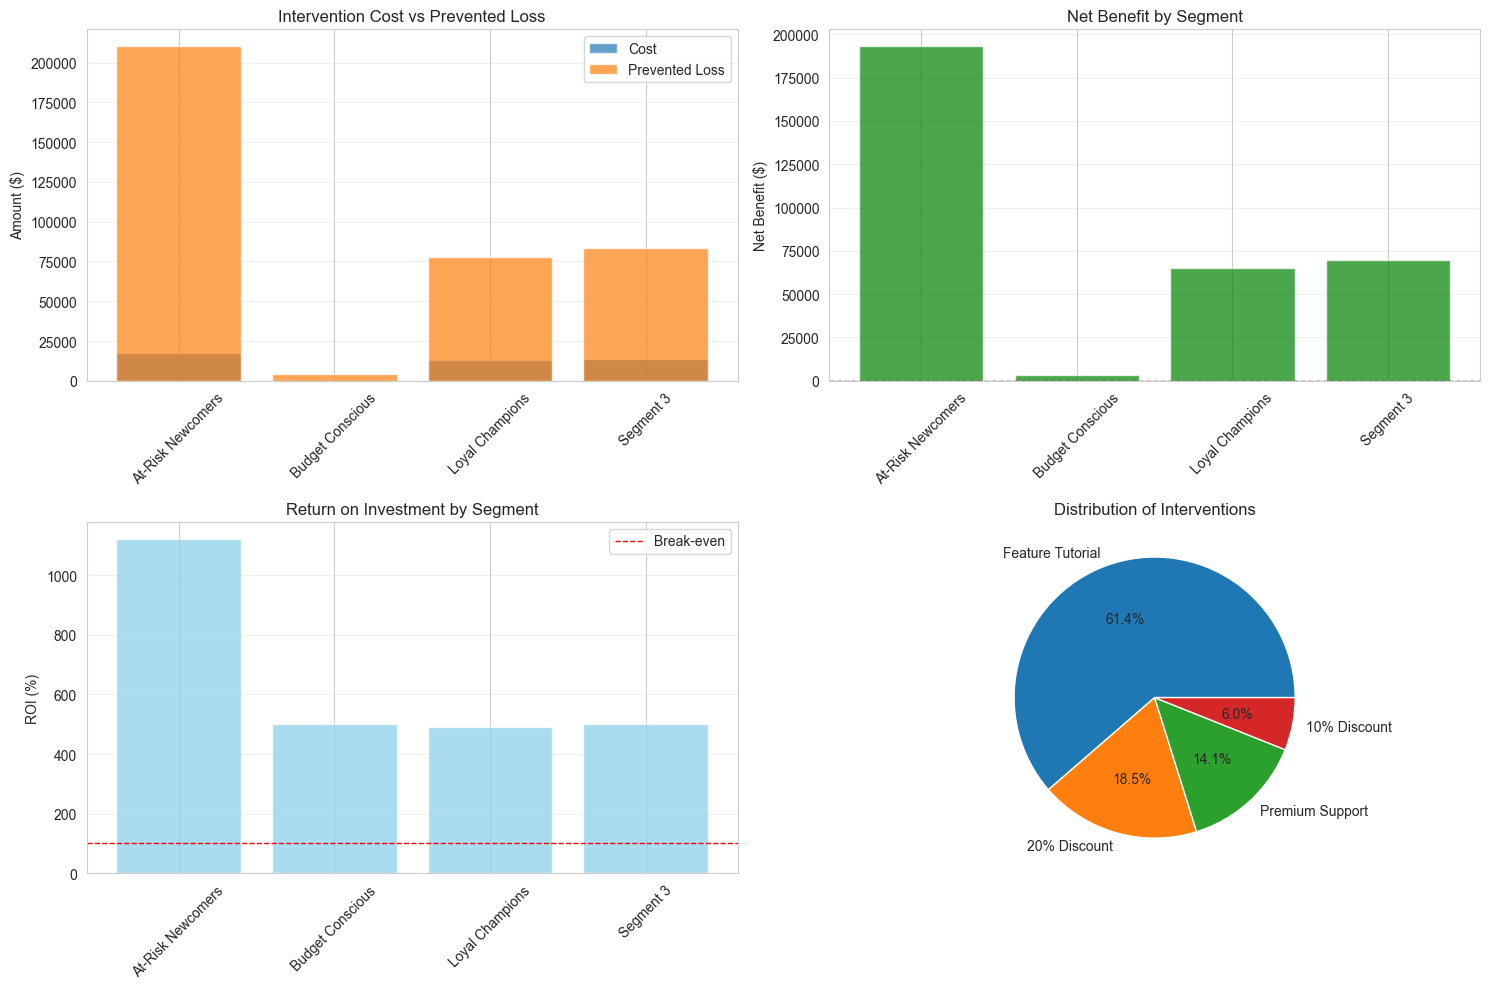

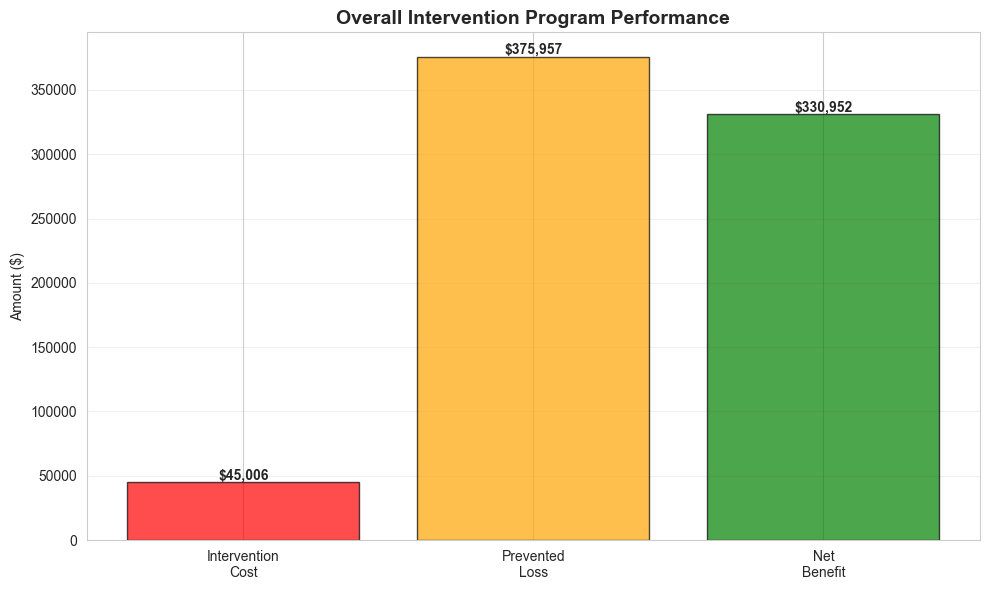

In [55]:
# STEP 7: VISUALIZATIONS
# ============================================================================

# ROI by Segment
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Costs vs Benefits
axes[0, 0].bar(segment_roi.index, segment_roi['Total_Cost'], label='Cost', alpha=0.7)
axes[0, 0].bar(segment_roi.index, segment_roi['Prevented_Loss'], label='Prevented Loss', alpha=0.7)
axes[0, 0].set_ylabel('Amount ($)')
axes[0, 0].set_title('Intervention Cost vs Prevented Loss')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Net Benefit
colors = ['green' if x > 0 else 'red' for x in segment_roi['Net_Benefit']]
axes[0, 1].bar(segment_roi.index, segment_roi['Net_Benefit'], color=colors, alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].set_ylabel('Net Benefit ($)')
axes[0, 1].set_title('Net Benefit by Segment')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. ROI Percentage
axes[1, 0].bar(segment_roi.index, segment_roi['ROI_%'], color='skyblue', alpha=0.7)
axes[1, 0].axhline(y=100, color='red', linestyle='--', linewidth=1, label='Break-even')
axes[1, 0].set_ylabel('ROI (%)')
axes[1, 0].set_title('Return on Investment by Segment')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Intervention Distribution
intervention_counts = data[data['High_Risk']]['Assigned_Intervention'].value_counts()
intervention_labels = [interventions[k]['name'] for k in intervention_counts.index]
axes[1, 1].pie(intervention_counts.values, labels=intervention_labels, autopct='%1.1f%%')
axes[1, 1].set_title('Distribution of Interventions')

plt.tight_layout()
plt.show()

# Overall metrics visualization
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Intervention\nCost', 'Prevented\nLoss', 'Net\nBenefit']
values = [total_cost, total_prevented_loss, total_net_benefit]
colors_chart = ['red', 'orange', 'green']

bars = ax.bar(metrics, values, color=colors_chart, alpha=0.7, edgecolor='black')
ax.set_ylabel('Amount ($)')
ax.set_title('Overall Intervention Program Performance', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${value:,.0f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [66]:
# STEP 8: SAVE RESULTS
# ============================================================================

# Save intervention data
data.to_csv('intervention_results.csv', index=False)

# Save summary
summary = {
    'total_customers': len(data),
    'high_risk_customers': data['High_Risk'].sum(),
    'total_intervention_cost': total_cost,
    'total_prevented_loss': total_prevented_loss,
    'net_benefit': total_net_benefit,
    'roi_percentage': (total_net_benefit / total_cost * 100) if total_cost > 0 else 0
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('intervention_summary.csv', index=False)

segment_roi.to_csv('segment_roi.csv')

print(f"\n✓ Intervention results saved!")
print(f"✓ ROI analysis saved!")


✓ Intervention results saved!
✓ ROI analysis saved!
